In [1]:
import os
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../../SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import  OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from numba import njit
import tifffile
from skimage.util import img_as_uint
from SyMBac.PSF import Camera
import ctypes

def call_malloc_trim():
    libc = ctypes.CDLL("libc.so.6")
    # The argument 0 means to trim as much memory as possible
    libc.malloc_trim(0)

In [2]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

In [3]:
zero_wavelength_PSF = np.array([[0,0,0],[0,1,0],[0,0,0]])
pad_amount = 100

radius = 175
wavelength = 0.65
NA = 1.45
n = 1.518
resize_amount = 1
pix_mic_conv = 0.065 / 3
apo_sigma = 10


In [4]:
PSF_darkred = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_darkred.tif")[70:-70,80:-80,80:-80]
PSF_green = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_green.tif")[70:-70,80:-80,80:-80]
PSF_orange = tifffile.imread("../../PSF_comparison/average_100x_PSF_postmag_orange.tif")[70:-70,80:-80,80:-80]

In [5]:
def prepare_ePSF(ePSF, pix_size_original_z, pix_size_original_xy, pix_size_new):
    
    ePSF = rescale(ePSF, (pix_size_original_z/pix_size_new, pix_size_original_xy / pix_size_new, pix_size_original_xy / pix_size_new), anti_aliasing=True)
    ePSF = ePSF - ePSF.min(axis=(1, 2))[:, np.newaxis, np.newaxis]
    return ePSF

real_PSFs = {
    "ePSF_darkred" : prepare_ePSF(PSF_darkred, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv),
    "ePSF_green" : prepare_ePSF(PSF_green, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv)
}

/tmp/ipykernel_153655/1634070185.py:4: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


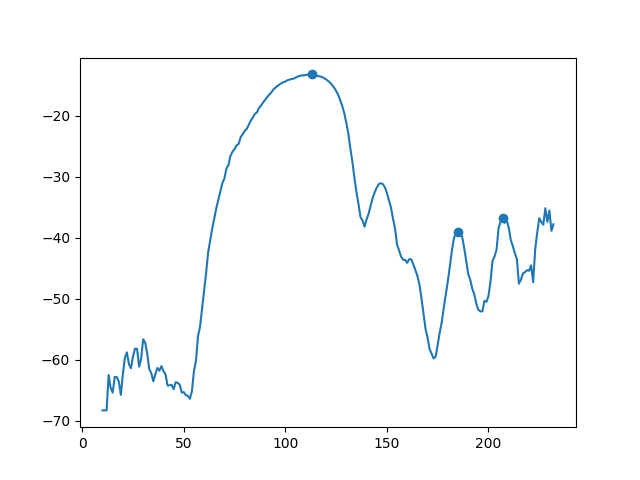

[113 185 207]


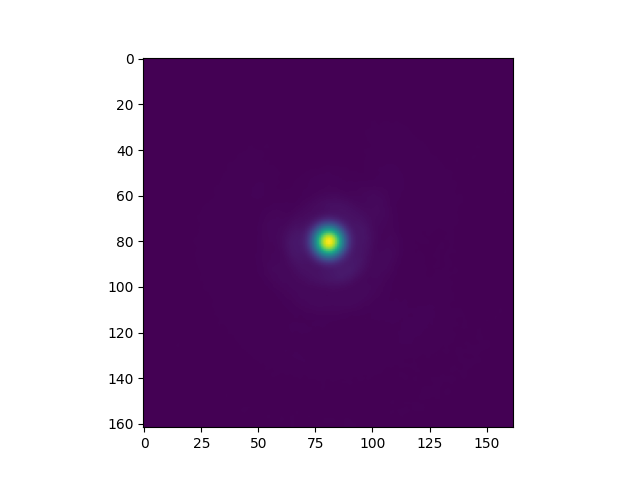

In [6]:
profile_integral = []
for layer in real_PSFs["ePSF_green"]:
    profile = layer[:,real_PSFs["ePSF_green"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -40, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
plt.show()
print(peaks)
PSF_green_centre_z =  peaks[0] #- 10 * 2
plt.imshow(real_PSFs["ePSF_green"][PSF_green_centre_z])

/tmp/ipykernel_153655/3216504970.py:4: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


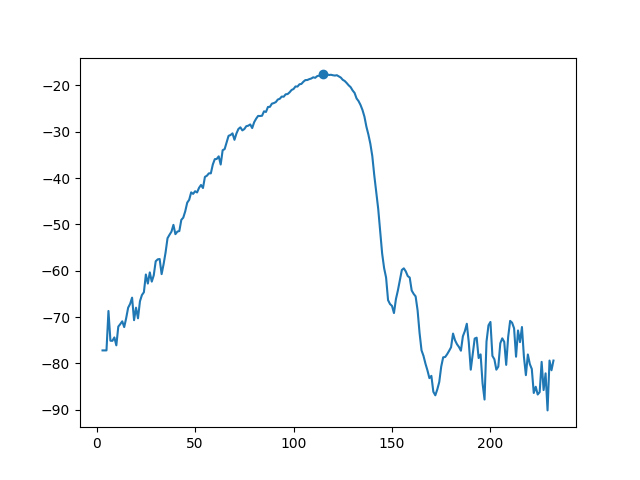

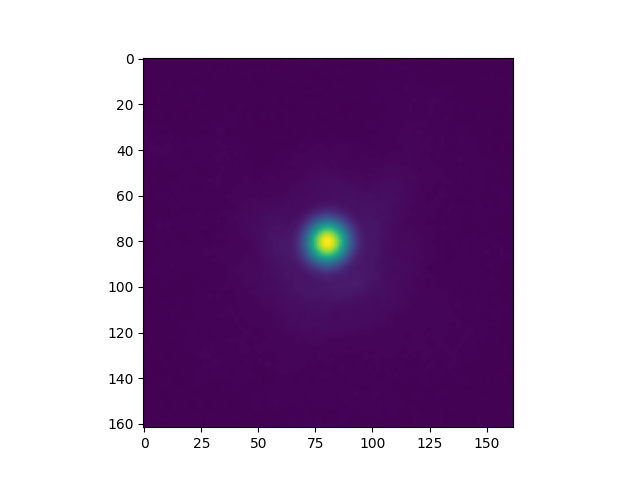

In [7]:
profile_integral = []
for layer in real_PSFs["ePSF_darkred"]:
    profile = layer[:,real_PSFs["ePSF_darkred"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -40, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
plt.show()
PSF_darkred_centre_z = peaks[0] - 3*3 # Check how the peaks line up with the tails
plt.imshow(real_PSFs["ePSF_darkred"][PSF_darkred_centre_z])

In [8]:
import pickle
import gc

In [9]:
cell_length = 3.02
max_width = 2.02
cell_widths = np.arange(0.5, max_width, 0.1)+0.02
cell_types = ["membrane"]
PSF_names = list(real_PSFs.keys())
PSF_centres = [PSF_darkred_centre_z, PSF_green_centre_z]

In [10]:
max_cell = raster_membrane_cell_3d(3/pix_mic_conv, cell_widths[-1]/pix_mic_conv, 0)

In [11]:
from itertools import product
import random
from skimage.transform import rotate
from scipy import ndimage

In [347]:
for s in tqdm(range(20)):
    mask_info = {}
    scene = np.zeros((max_cell.shape[0]+4, 3000, 3000))
    masks = np.zeros((3000, 3000)).astype(np.uint16)
    num_cells = 80
    z_center = scene.shape[0] // 2
    occupied = np.zeros_like(scene, dtype=bool)  # Track occupied spaces
    mask_counter = 1
    for _ in tqdm(range(num_cells)):
        # Generate a random cell
        width = random.choice(cell_widths)
        a_cell = raster_membrane_cell_3d(np.random.uniform(width, width*4) / pix_mic_conv, width / pix_mic_conv, 0)
        angle = np.random.uniform(0, 360)
        a_cell = ndimage.rotate(a_cell, angle, axes=(1, 2), reshape=True)
    
        placed = False
        attempts = 0
        max_attempts = 50  # Prevent infinite loop by limiting placement attempts
    
        while not placed and attempts < max_attempts:
            attempts += 1
    
            # Calculate z-offset to center the cell in z-axis
            cell_height = a_cell.shape[0]
            z_offset = z_center - cell_height // 2
    
            # Ensure z_offset is within bounds
            z_offset = max(z_offset, 0)
            z_offset = min(z_offset, scene.shape[0] - cell_height)
    
            # Randomly choose x, y offsets
            max_x_offset = scene.shape[1] - a_cell.shape[1]
            max_y_offset = scene.shape[2] - a_cell.shape[2]
    
            x_offset = random.randint(0, max_x_offset)
            y_offset = random.randint(0, max_y_offset)
    
            # Check if the chosen area is free of other cells
            if not np.any(occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]]):
                # Place the cell in the scene
                scene[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += a_cell
                # Mark these coordinates as occupied
                occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] = True
                placed = True
                masks[x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += (ndimage.binary_fill_holes(a_cell.sum(axis=0) > 0) * mask_counter).astype(np.uint16)
                individual_mask = {}
                individual_mask["width"] = width
                individual_mask["angle"] = angle
                individual_mask["coords_x"] = [x_offset, x_offset + a_cell.shape[1]]
                individual_mask["coords_y"] = [y_offset, y_offset + a_cell.shape[2]]
                mask_info[mask_counter] = individual_mask
                mask_counter += 1
        if not placed:
            print(f"Failed to place cell after {max_attempts} attempts.")


    my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
    noise = my_camera.render_dark_image((1000,1000), False)
    
    scene_centre = scene.shape[0]//2
    for PSF_name, PSF_centre in zip(tqdm(PSF_names), PSF_centres):
        PSF = real_PSFs[PSF_name]
        scene_conv_idxs = np.arange(scene.shape[0])
        PSF_conv_idxs = np.arange(PSF_centre-scene_centre,PSF_centre+scene_centre)
        convolved_projection = np.array(
            [convolve_rescale(scene[scene_conv_idx].astype(np.float32), PSF[PSF_conv_idx], 1, False) for scene_conv_idx, PSF_conv_idx in zip(scene_conv_idxs, tqdm(PSF_conv_idxs))]
        )

        resized_image = resize(convolved_projection.sum(axis=0), (1000,1000))
        resized_image = img_as_uint(resized_image/resized_image.max())
        resized_image = ((resized_image / 100 )+ noise).astype(np.uint16)
        resized_masks = img_as_uint(resize(masks, (1000,1000), order = 0))
    
        with open(f'scattered_cells_{PSF_name}/{str(s).zfill(1)}.pickle', 'wb') as handle:
            pickle.dump(mask_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        Image.fromarray(resized_image).save(f'scattered_cells_{PSF_name}/{str(s).zfill(1)}.png')
        Image.fromarray(resized_masks).save(f'scattered_cells_{PSF_name}/{str(s).zfill(1)}_masks.png')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [12]:
for s in tqdm(range(5)):
    mask_info = {}
    scene = np.zeros((max_cell.shape[0]+4, 3000, 3000))
    masks = np.zeros((3000, 3000)).astype(np.uint16)
    num_cells = 80
    z_center = scene.shape[0] // 2
    occupied = np.zeros_like(scene, dtype=bool)  # Track occupied spaces
    mask_counter = 1
    for _ in tqdm(range(num_cells)):
        # Generate a random cell
        width = random.choice(cell_widths)
        a_cell = raster_membrane_cell_3d(np.random.uniform(width, width*4) / pix_mic_conv, width / pix_mic_conv, 0)
        angle = np.random.uniform(0, 360)
        a_cell = ndimage.rotate(a_cell, angle, axes=(1, 2), reshape=True)
    
        placed = False
        attempts = 0
        max_attempts = 50  # Prevent infinite loop by limiting placement attempts
    
        while not placed and attempts < max_attempts:
            attempts += 1
    
            # Calculate z-offset to center the cell in z-axis
            cell_height = a_cell.shape[0]
            z_offset = z_center - cell_height // 2
    
            # Ensure z_offset is within bounds
            z_offset = max(z_offset, 0)
            z_offset = min(z_offset, scene.shape[0] - cell_height)
    
            # Randomly choose x, y offsets
            max_x_offset = scene.shape[1] - a_cell.shape[1]
            max_y_offset = scene.shape[2] - a_cell.shape[2]
    
            x_offset = random.randint(0, max_x_offset)
            y_offset = random.randint(0, max_y_offset)
    
            # Check if the chosen area is free of other cells
            if not np.any(occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]]):
                # Place the cell in the scene
                scene[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += a_cell
                # Mark these coordinates as occupied
                occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] = True
                placed = True
                masks[x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += (ndimage.binary_fill_holes(a_cell.sum(axis=0) > 0) * mask_counter).astype(np.uint16)
                individual_mask = {}
                individual_mask["width"] = width
                individual_mask["angle"] = angle
                individual_mask["coords_x"] = [x_offset, x_offset + a_cell.shape[1]]
                individual_mask["coords_y"] = [y_offset, y_offset + a_cell.shape[2]]
                mask_info[mask_counter] = individual_mask
                mask_counter += 1
        if not placed:
            print(f"Failed to place cell after {max_attempts} attempts.")

    my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
    noise = my_camera.render_dark_image((1000,1000), False)
    
    scene_centre = scene.shape[0]//2
    for PSF_name, PSF_centre in zip(tqdm(PSF_names), PSF_centres):
        PSF = real_PSFs[PSF_name]
        scene_conv_idxs = np.arange(scene.shape[0])
        PSF_conv_idxs = np.arange(PSF_centre-scene_centre,PSF_centre+scene_centre)
        convolved_projection = np.array(
            [convolve_rescale(scene[scene_conv_idx].astype(np.float32), PSF[PSF_conv_idx], 1, False) for scene_conv_idx, PSF_conv_idx in zip(scene_conv_idxs, tqdm(PSF_conv_idxs))]
        )

        resized_image = resize(convolved_projection.sum(axis=0), (1000,1000))
        resized_image = img_as_uint(resized_image/resized_image.max())
        resized_image = ((resized_image / 100 )+ noise).astype(np.uint16)
        resized_masks = img_as_uint(resize(masks, (1000,1000), order = 0))
    
        with open(f'scattered_cells_val_{PSF_name}/{str(s).zfill(1)}.pickle', 'wb') as handle:
            pickle.dump(mask_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        Image.fromarray(resized_image).save(f'scattered_cells_val_{PSF_name}/{str(s).zfill(1)}.png')
        Image.fromarray(resized_masks).save(f'scattered_cells_val_{PSF_name}/{str(s).zfill(1)}_masks.png')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

In [14]:
mask_info = {}
scene = np.zeros((max_cell.shape[0]+4, 3000, 3000))
masks = np.zeros((3000, 3000)).astype(np.uint16)
num_cells = 200
z_center = scene.shape[0] // 2
occupied = np.zeros_like(scene, dtype=bool)  # Track occupied spaces
mask_counter = 1
for _ in tqdm(range(num_cells)):
    # Generate a random cell
    width = random.choice(cell_widths)
    a_cell = raster_membrane_cell_3d(np.random.uniform(width, width*4) / pix_mic_conv, width / pix_mic_conv, 0)
    angle = np.random.uniform(0, 360)
    a_cell = ndimage.rotate(a_cell, angle, axes=(1, 2), reshape=True)

    placed = False
    attempts = 0
    max_attempts = 50  # Prevent infinite loop by limiting placement attempts

    while not placed and attempts < max_attempts:
        attempts += 1

        # Calculate z-offset to center the cell in z-axis
        cell_height = a_cell.shape[0]
        z_offset = z_center - cell_height // 2

        # Ensure z_offset is within bounds
        z_offset = max(z_offset, 0)
        z_offset = min(z_offset, scene.shape[0] - cell_height)

        # Randomly choose x, y offsets
        max_x_offset = scene.shape[1] - a_cell.shape[1]
        max_y_offset = scene.shape[2] - a_cell.shape[2]

        x_offset = random.randint(0, max_x_offset)
        y_offset = random.randint(0, max_y_offset)

        # Check if the chosen area is free of other cells
        if not np.any(occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]]):
            # Place the cell in the scene
            scene[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += a_cell
            # Mark these coordinates as occupied
            occupied[z_offset:z_offset + cell_height, x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] = True
            placed = True
            masks[x_offset:x_offset + a_cell.shape[1], y_offset:y_offset + a_cell.shape[2]] += (ndimage.binary_fill_holes(a_cell.sum(axis=0) > 0) * mask_counter).astype(np.uint16)
            individual_mask = {}
            individual_mask["width"] = width
            individual_mask["angle"] = angle
            individual_mask["coords_x"] = [x_offset, x_offset + a_cell.shape[1]]
            individual_mask["coords_y"] = [y_offset, y_offset + a_cell.shape[2]]
            mask_info[mask_counter] = individual_mask
            mask_counter += 1
    if not placed:
        print(f"Failed to place cell after {max_attempts} attempts.")

my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
noise = my_camera.render_dark_image((1000,1000), False)

scene_centre = scene.shape[0]//2
for PSF_name, PSF_centre in zip(tqdm([PSF_names[0]]), [PSF_centres[0]]):
    PSF = real_PSFs[PSF_name]
    scene_conv_idxs = np.arange(scene.shape[0])
    PSF_conv_idxs = np.arange(PSF_centre-scene_centre,PSF_centre+scene_centre)
    convolved_projection = np.array(
        [convolve_rescale(scene[scene_conv_idx].astype(np.float32), PSF[PSF_conv_idx], 1, False) for scene_conv_idx, PSF_conv_idx in zip(scene_conv_idxs, tqdm(PSF_conv_idxs))]
    )

    resized_image = resize(convolved_projection.sum(axis=0), (1000,1000))
    resized_image = img_as_uint(resized_image/resized_image.max())
    resized_image = ((resized_image / 100 )+ noise).astype(np.uint16)
    resized_masks = img_as_uint(resize(masks, (1000,1000), order = 0))

    with open(f'scattered_cells_for_figure_{PSF_name}/{str(s).zfill(1)}.pickle', 'wb') as handle:
        pickle.dump(mask_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

    Image.fromarray(resized_image).save(f'scattered_cells_for_figure_{PSF_name}/{str(s).zfill(1)}.png')
    Image.fromarray(resized_masks).save(f'scattered_cells_for_figure_{PSF_name}/{str(s).zfill(1)}_masks.png')

  0%|          | 0/200 [00:00<?, ?it/s]

Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.
Failed to place cell after 50 attempts.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

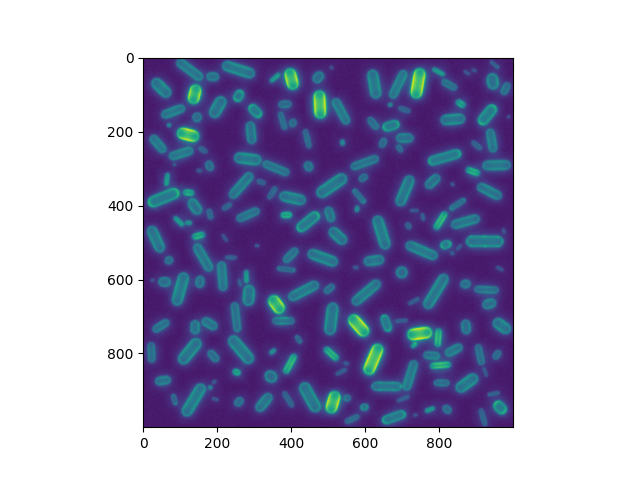

In [15]:
plt.imshow(resized_image)